# <center>Deep Neural Network Example</center>

### Declare Factory

factory will be the object that executes the training and testing.

In [1]:
from ROOT import TMVA, TFile, TTree, TCut, TString

Welcome to JupyROOT 6.14/04


We will get the data from the file *inputdata.root*, which it's placed in the same folder as this notebook.

In [2]:
TMVA.Tools.Instance()

inputFile = TFile.Open("inputdata.root")
outputFile = TFile.Open("TMVAOutputDNN.root", "RECREATE")

factory = TMVA.Factory("TMVAClassification", outputFile,
        "!V:!Silent:Color:!DrawProgressBar:AnalysisType=Classification")

### Setup Dataset(s)

In [3]:
tsignal = inputFile.Get("Sig")
tbackground = inputFile.Get("Bkg")

In [4]:
tsignal.Print()

******************************************************************************
*Tree    :Sig       : TreeS                                                  *
*Entries :     6000 : Total =           98564 bytes  File  Size =      89799 *
*        :          : Tree compression factor =   1.08                       *
******************************************************************************
*Br    0 :var1      : var1/F                                                 *
*Entries :     6000 : Total  Size=      24553 bytes  File Size  =      22365 *
*Baskets :        1 : Basket Size=      32000 bytes  Compression=   1.08     *
*............................................................................*
*Br    1 :var2      : var2/F                                                 *
*Entries :     6000 : Total  Size=      24553 bytes  File Size  =      22361 *
*Baskets :        1 : Basket Size=      32000 bytes  Compression=   1.08     *
*...................................................

In [5]:
tbackground.Print()

******************************************************************************
*Tree    :Bkg       : TreeB                                                  *
*Entries :     6000 : Total =          123132 bytes  File  Size =     112331 *
*        :          : Tree compression factor =   1.08                       *
******************************************************************************
*Br    0 :var1      : var1/F                                                 *
*Entries :     6000 : Total  Size=      24553 bytes  File Size  =      22322 *
*Baskets :        1 : Basket Size=      32000 bytes  Compression=   1.08     *
*............................................................................*
*Br    1 :var2      : var2/F                                                 *
*Entries :     6000 : Total  Size=      24553 bytes  File Size  =      22382 *
*Baskets :        1 : Basket Size=      32000 bytes  Compression=   1.08     *
*...................................................

As you can see, we have 4 variables. In the background tree there's also a column for the weights.

### Declare Variables in DataLoader

We will add those 4 variables to out loader object, but we'll incorporate 2 more variables, which depend on the others.

Loader is the object that will be processed by the factory.

In [6]:
loader = TMVA.DataLoader("dataset_dnn") # For ANN we use just "dataset"

loader.AddVariable("var1")
loader.AddVariable("var2")
loader.AddVariable("var3")
loader.AddVariable("var4")
loader.AddVariable("var5 := var1-var3")
loader.AddVariable("var6 := var1+var2")

In [7]:
loader.AddSignalTree(tsignal)
loader.AddBackgroundTree(tbackground) 
loader.PrepareTrainingAndTestTree(TCut(""),
        "nTrain_Signal=1000:nTrain_Background=1000:SplitMode=Random:NormMode=NumEvents:!V")

DataSetInfo              : [dataset_dnn] : Added class "Signal"
                         : Add Tree Sig of type Signal with 6000 events
DataSetInfo              : [dataset_dnn] : Added class "Background"
                         : Add Tree Bkg of type Background with 6000 events
                         : Dataset[dataset_dnn] : Class index : 0  name : Signal
                         : Dataset[dataset_dnn] : Class index : 1  name : Background


### Configure Network Layout

General setup for out dnn

In [8]:
# General layout
layoutString = TString("Layout=TANH|128,TANH|128,TANH|128,LINEAR");

# Training strategies
training0 = TString("LearningRate=1e-1,Momentum=0.9,Repetitions=1,"
                        "ConvergenceSteps=2,BatchSize=256,TestRepetitions=10,"
                        "WeightDecay=1e-4,Regularization=L2,"
                        "DropConfig=0.0+0.5+0.5+0.5, Multithreading=True")
training1 = TString("LearningRate=1e-2,Momentum=0.9,Repetitions=1,"
                        "ConvergenceSteps=2,BatchSize=256,TestRepetitions=10,"
                        "WeightDecay=1e-4,Regularization=L2,"
                        "DropConfig=0.0+0.0+0.0+0.0, Multithreading=True")
trainingStrategyString = TString("TrainingStrategy=")
trainingStrategyString += training0 + TString("|") + training1

# General Options
dnnOptions = TString("!H:!V:ErrorStrategy=CROSSENTROPY:VarTransform=N:"
        "WeightInitialization=XAVIERUNIFORM")
dnnOptions.Append(":")
dnnOptions.Append(layoutString)
dnnOptions.Append(":")
dnnOptions.Append(trainingStrategyString)

'!H:!V:ErrorStrategy=CROSSENTROPY:VarTransform=N:WeightInitialization=XAVIERUNIFORM:Layout=TANH|128,TANH|128,TANH|128,LINEAR:TrainingStrategy=LearningRate=1e-1,Momentum=0.9,Repetitions=1,ConvergenceSteps=2,BatchSize=256,TestRepetitions=10,WeightDecay=1e-4,Regularization=L2,DropConfig=0.0+0.5+0.5+0.5, Multithreading=True|LearningRate=1e-2,Momentum=0.9,Repetitions=1,ConvergenceSteps=2,BatchSize=256,TestRepetitions=10,WeightDecay=1e-4,Regularization=L2,DropConfig=0.0+0.0+0.0+0.0, Multithreading=True'

### Booking Methods

Define the method that will be used by the factory object

In [9]:
# Standard implementation, no dependencies.
stdOptions =  dnnOptions + ":Architecture=CPU"
factory.BookMethod(loader, TMVA.Types.kDNN, "DNN", stdOptions)

# CPU implementation, using BLAS
#cpuOptions = dnnOptions + ":Architecture=CPU"
#factory.BookMethod(loader, TMVA.Types.kDNN, "DNN CPU", cpuOptions)

<ROOT.TMVA::MethodDNN object ("DNN") at 0x6a51a50>

Factory                  : Booking method: DNN
                         : 
DNN                      : [dataset_dnn] : Create Transformation "N" with events from all classes.
                         : 
                         : Transformation, Variable selection : 
                         : Input : variable 'var1' <---> Output : variable 'var1'
                         : Input : variable 'var2' <---> Output : variable 'var2'
                         : Input : variable 'var3' <---> Output : variable 'var3'
                         : Input : variable 'var4' <---> Output : variable 'var4'
                         : Input : variable 'var5' <---> Output : variable 'var5'
                         : Input : variable 'var6' <---> Output : variable 'var6'
DataSetFactory           : [dataset_dnn] : Number of events in input trees
                         : 
                         : 
                         : Number of training and testing events
                         : ------------------

### Train Methods

In [10]:
factory.TrainAllMethods()

Factory                  : Train all methods
Factory                  : [dataset_dnn] : Create Transformation "I" with events from all classes.
                         : 
                         : Transformation, Variable selection : 
                         : Input : variable 'var1' <---> Output : variable 'var1'
                         : Input : variable 'var2' <---> Output : variable 'var2'
                         : Input : variable 'var3' <---> Output : variable 'var3'
                         : Input : variable 'var4' <---> Output : variable 'var4'
                         : Input : variable 'var5' <---> Output : variable 'var5'
                         : Input : variable 'var6' <---> Output : variable 'var6'
TFHandler_Factory        : Variable        Mean        RMS   [        Min        Max ]
                         : -----------------------------------------------------------
                         :     var1:   0.042398     1.6637   [    -4.9583     4.3515 ]
          

### Test and Evaluate Methods

In [11]:
factory.TestAllMethods()
factory.EvaluateAllMethods()

Factory                  : Test all methods
Factory                  : Test method: DNN for Classification performance
                         : 
DNN                      : [dataset_dnn] : Evaluation of DNN on testing sample (10000 events)
                         : Elapsed time for evaluation of 10000 events: 0.719 sec       
Factory                  : Evaluate all methods
Factory                  : Evaluate classifier: DNN
                         : 
TFHandler_DNN            : Variable        Mean        RMS   [        Min        Max ]
                         : -----------------------------------------------------------
                         :     var1:   0.067343    0.35861   [    -1.2021     1.0886 ]
                         :     var2:   0.053830    0.32258   [    -1.0198     1.0366 ]
                         :     var3:   0.065106    0.35083   [    -1.0158    0.99984 ]
                         :     var4:    0.12225    0.42095   [    -1.2661     1.0694 ]
                    

### Plot ROC Curve

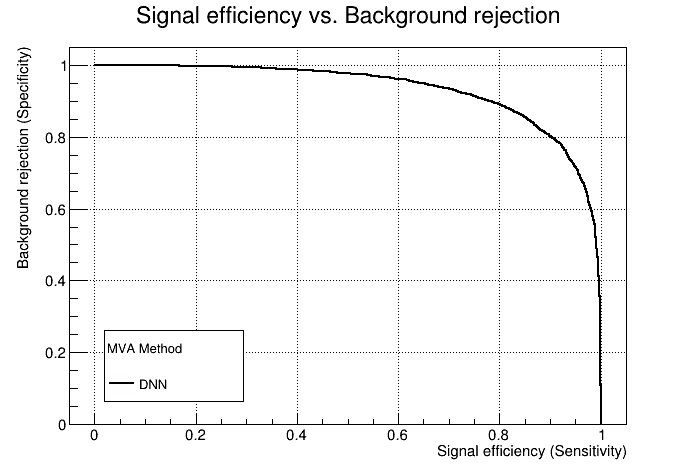

In [12]:
c = factory.GetROCCurve(loader)
c.Draw()

We can see the classifier gives good outcomes according to the evaluation and the ROC curve.